# Tutorial 5: Comparison of SSALib and Rssa

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/ssalib/blob/main/notebooks/05_Rssa_comparison.ipynb)

In this tutorial, you will learn:
- How to compare Singular Spectrum Analysis with SSALib and the [Rssa R package](https://cran.r-project.org/package=Rssa).
- How to pass input variables and retrieve results between Python and R environment using the [`rpy2` package](https://rpy2.github.io/doc/latest/html/index.html) and the R magic command.

To further learn about the features of the Rssa R package, we recommend the following reference:
> Golyandina, N., Korobeynikov, A., & Zhigljavsky, A. (2018). Singular Spectrum Analysis with R. Berlin, Heidelberg: Springer. https://doi.org/10.1007/978-3-662-57380-8

**Note**: to run this notebook locally, you need to have R and the `rpy2` module installed and configured correctly.

## Configure `rpy2` and Load Extension

- The `rpy2` library enables the execution of R code within a Python environment. Uncomment `!pip install rpy2` to install it if it's not already available.
- The `os.environ['R_HOME']` variable specifies the path to the `R_HOME` directory, which points to the local R installation path (e.g., `C:/Program Files/R/R-4.4.0`).
- `%load_ext rpy2.ipython` is an IPython-specific magic command to load the `rpy2` extension, enabling the use of R code directly within Jupyter Notebook cells.

In [1]:
# Uncomment to install rpy2 if not installed
# !pip install rpy2

# Edit the R home path to point to the correct 'R_HOME' variable locally
import os  # comment if not needed

os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.0'  # comment if not needed

%load_ext rpy2.ipython

C:\Users\damsd\Anaconda3\envs\pythonProject\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


## SSA using SSALib

In the next cells, we perform SSA using the SSALib package and the Sea Surface Temperature time series, so we can compare the results with the results of the decomposition obtained with
the Rssa R package.

### Imports

In [2]:
#!pip install git+https://github.com/ADSCIAN/ssalib.git # <-- Uncomment to install if needed
import pandas as pd
import matplotlib.pyplot as plt
from ssalib import SingularSpectrumAnalysis
from ssalib.datasets import load_sst

### Load Data

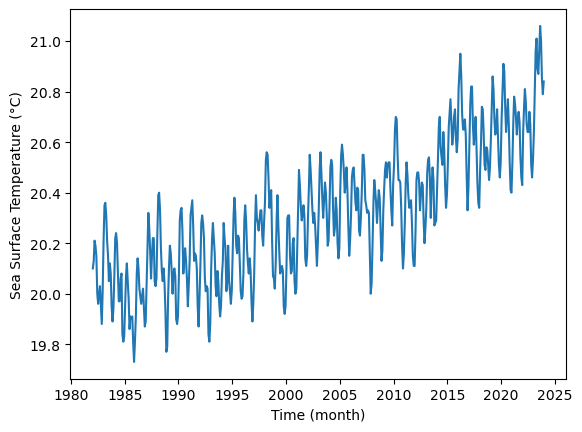

In [3]:
sst = load_sst()  # load sea surface temperature time series
# plot the series
fig_ts, ax_ts = plt.subplots()
ax_ts.plot(sst, label='Original')
_ = ax_ts.set_ylabel('Sea Surface Temperature (°C)')
_ = ax_ts.set_xlabel('Time (month)')

### Run SSA and Plot Results

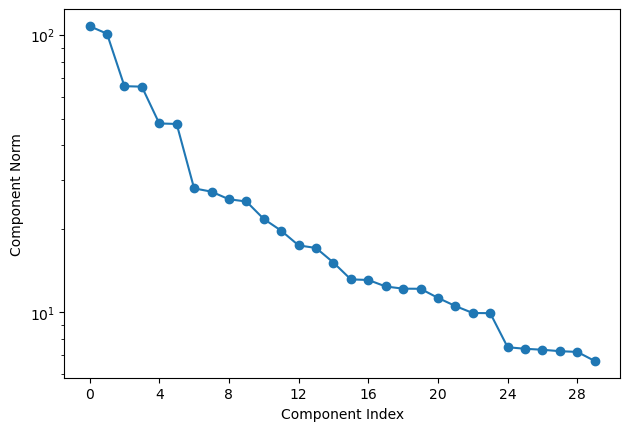

In [4]:
ssa = SingularSpectrumAnalysis(sst)  # init SSA with default params
ssa.decompose()  # run SVD decomposition
# plot the first 30 singular values
fig_values, ax_values = ssa.plot(kind='values', n_components=30, marker='o', label='SSALib Singular Values')

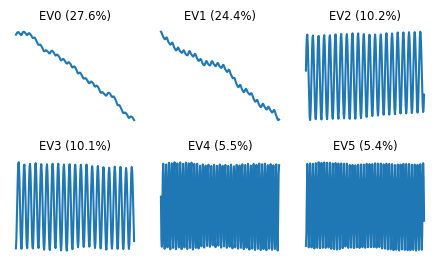

In [5]:
# plot the first 6 vectors
_ = ssa.plot(kind='vectors', n_components=6)

### Reconstruct Groups

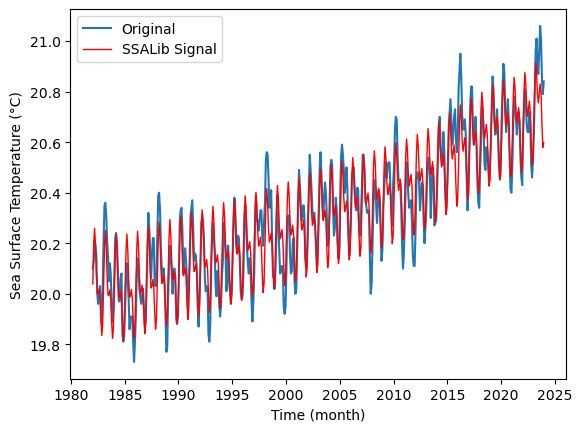

In [6]:
groups = {
    'trend': [0, 1],
    'annual': [2, 3],
    'semiannual': [4, 5]
}
ssa.reconstruct(groups=groups)

# create clean signal and add it to the plot
signal = (ssa['trend'] + ssa['annual'] + ssa[
    'semiannual']) * ssa.std_ + ssa.mean_
ax_ts.plot(signal, color='r', lw=1., label='SSALib Signal')
ax_ts.legend()
fig_ts

## SSA using Rssa

In this section, we decompose the SST time series using the R package Rssa.

### Test rpy2 extension and Rssa installation

- If `%load_ext rpy2.ipython` has been correctly executed, we can use the magic command `%%R` to run R code cells directly within a Python Jupyter notebook.
- We install the `Rssa` package if not install and load it.

In [7]:
%%R
# Test R extension
cat("R extension is working!\n")

if (!requireNamespace("Rssa", quietly = TRUE)) {
  install.packages("Rssa", repos = "http://cran.us.r-project.org")
}
library(Rssa)
cat("rssa package is now loaded.\n")

R extension is working!
rssa package is now loaded.


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: svd
Loading required package: forecast
This is forecast 8.22.0 
  Want to stay up-to-date? Read the Hyndsight blog:
  https://robjhyndman.com/hyndsight/

Attaching package: 'Rssa'

The following object is masked from 'package:stats':

    decompose



### Run SSA and Plot Results

- We use the `%%R` magic command to execute R code while passing variables between Python and R (`-i` for input, `-o` for output).
- We have to normalize `sst` variable to have zero mean and unit variance, since this is the default behavior in `SSALib`.
- We apply SSA to the standardized time series to decompose it into components.
- We extract the singular values (`sigma`) from the `ssa` object.
- We plot the first 30 singular values to visualize the components' strength.

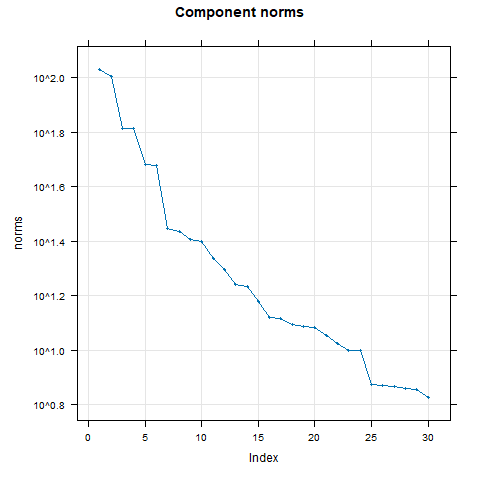

In [8]:
%%R -i sst -o ssa_values
sst_std = (sst - mean(sst)) / sd(sst)
# Perform Singular Spectrum Analysis (SSA) on the sst time series
ssa_object <- ssa(sst_std)
ssa_values <- ssa_object$sigma
# Plot the singular values
plot(ssa_object, numvalues=30)

- We compare the singular values obtained from both SSA decompositions on the same plot.

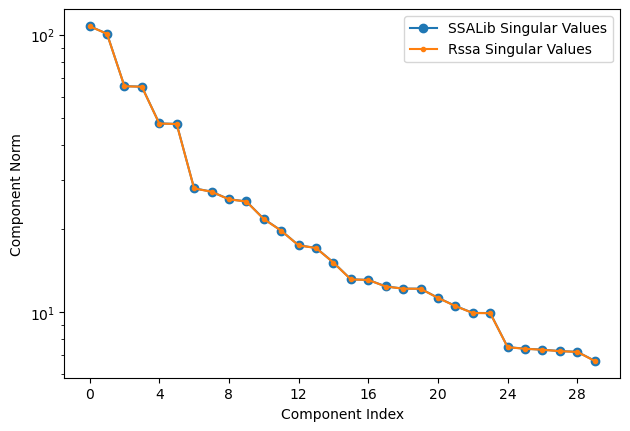

In [9]:
ax_values.plot(ssa_values[:30], marker='.', label='Rssa Singular Values')
ax_values.legend()
fig_values

- We plot the left eigenvectors.
- Eigenvectors can be flipped, yet, the SVD resulting system is equivalent.

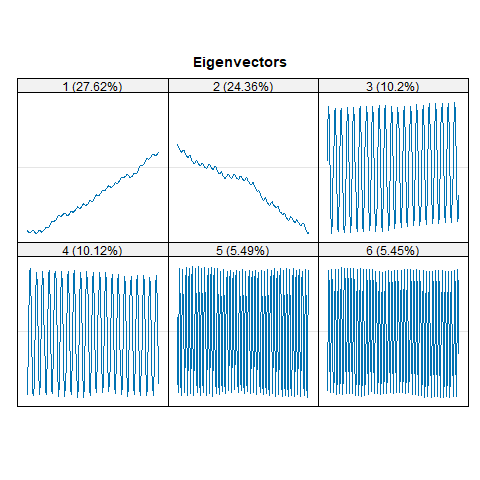

In [10]:
%%R
# Plot the eigen vectors
plot(ssa_object, type="vectors", numvectors=6)

### Reconstruct Groups

- We reconstruct groups trend `c(1,2)`, annual cycle `c(3,4)`, and semiannual cycle `c(5,6)`using the reconstruct method.
- Reconstruction results are retrieved by group order `$F1`, `$F2`, and `$F3`
- We combine all components to form the **reconstructed signal** (`rssa_signal`) and plot the results

**Note**: R indexing starts at 1 while Python indexing starts at 0, which is why groups indices are shifted compared to the SSALib reconstruction above.

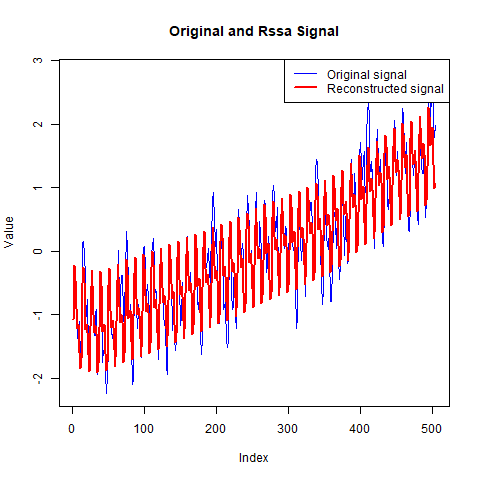

In [11]:
%%R -o rssa_signal
result <- reconstruct(ssa_object, groups=list(c(1, 2), c(3, 4), c(5, 6)))

# Extract components
rssa_trend <- result$F1  # Trend component
rssa_annual <- result$F2  # Annual component
rssa_semiannual <- result$F3  # Semi-annual component

rssa_signal <- rssa_trend + rssa_annual + rssa_semiannual
# Plot the first line
plot(sst_std, type="l", col="blue", lwd=1, main="Original and Rssa Signal",
     ylab="Value", xlab="Index")

# Add the second line to the same plot
lines(rssa_signal, type="l", col="red", lwd=2)

# Add a legend to differentiate the two lines
legend("topright", legend=c("Original signal", "Reconstructed signal"),
       col=c("blue", "red"), lwd=c(1, 2))

- Finally, we rescale the Rssa signal and compare both signals obtained using SSALib and Rssa.

Note: The `ssa._ix` attribute holds the pandas datetime index of the SST time series. We use it to reindex the Rssa signal.


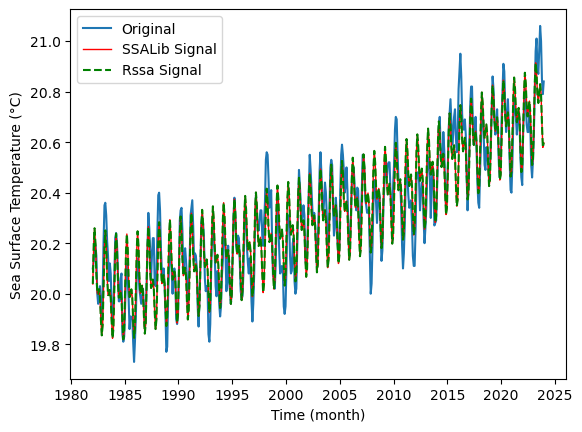

In [12]:
rssa_signal_rescaled = rssa_signal * ssa.std_ + ssa.mean_
ax_ts.plot(ssa._ix, rssa_signal_rescaled, color='g', ls = '--', label='Rssa Signal')
ax_ts.legend()
fig_ts